import python package

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ssam
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
from matplotlib.path import Path
from matplotlib_scalebar.scalebar import ScaleBar
import scanpy as sc
import cv2
from sklearn import preprocessing
from sklearn.cluster import AgglomerativeClustering
from skimage import measure
from ssam.utils import corr, calc_ctmap, calc_corrmap, flood_fill, calc_kde
from scipy.ndimage import zoom
from matplotlib.colors import ListedColormap

2023-01-17 00:37:31.500153: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-17 00:37:32.910757: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/R/4.0.2/lib/R/lib:/usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/local/cuda/extras/CUPTI/lib64
2023-01-17 00:37:32.910909: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/R/4.0.2/lib/R/lib:/usr/l

In [2]:
def find_domains(binned_ctmaps, n_clusters=3, norm_thres=0, merge_thres=0.6, merge_remote=True):
    def find_neighbors(m, l):
        neighbors = set()
        for x, y, z in zip(*np.where(m == l)):
            neighbors.add(m[x - 1, y    , z    ])
            neighbors.add(m[x + 1, y    , z    ])
            neighbors.add(m[x    , y - 1, z    ])
            neighbors.add(m[x    , y + 1, z    ])
            neighbors.add(m[x    , y    , z - 1])
            neighbors.add(m[x    , y    , z + 1])
            neighbors.add(m[x - 1, y - 1, z    ])
            neighbors.add(m[x + 1, y - 1, z    ])
            neighbors.add(m[x - 1, y + 1, z    ])
            neighbors.add(m[x + 1, y + 1, z    ])
            neighbors.add(m[x - 1, y    , z - 1])
            neighbors.add(m[x + 1, y    , z - 1])
            neighbors.add(m[x - 1, y    , z + 1])
            neighbors.add(m[x + 1, y    , z + 1])
            neighbors.add(m[x    , y - 1, z - 1])
            neighbors.add(m[x    , y + 1, z - 1])
            neighbors.add(m[x    , y - 1, z + 1])
            neighbors.add(m[x    , y + 1, z + 1])
            neighbors.add(m[x - 1, y - 1, z - 1])
            neighbors.add(m[x + 1, y - 1, z - 1])
            neighbors.add(m[x - 1, y - 1, z + 1])
            neighbors.add(m[x + 1, y - 1, z + 1])
            neighbors.add(m[x - 1, y + 1, z - 1])
            neighbors.add(m[x + 1, y + 1, z - 1])
            neighbors.add(m[x - 1, y + 1, z + 1])
            neighbors.add(m[x + 1, y + 1, z + 1])
        return neighbors
    
    binned_ctmaps_norm = np.sum(binned_ctmaps, axis=3)
    shape = binned_ctmaps_norm.shape
    ctvf_vecs = binned_ctmaps[binned_ctmaps_norm > norm_thres]
    ctvf_vecs_normalized = preprocessing.normalize(ctvf_vecs, norm='l1', axis=1)
    clustering =  AgglomerativeClustering(n_clusters=n_clusters, linkage='ward', affinity='euclidean').fit(ctvf_vecs_normalized)
    labels_predicted = clustering.labels_ + 1
    layer_map = np.zeros(binned_ctmaps_norm.shape)
    layer_map[binned_ctmaps_norm > norm_thres] = labels_predicted
    layer_map = measure.label(layer_map)
    
    if merge_thres < 1.0:
        while True:
            uniq_labels = np.array(list(set(list(np.ravel(layer_map))) - set([0])))
            if not merge_remote:
                layer_map_padded = np.pad(layer_map, 1, mode='constant', constant_values=0)
                neightbors_dic = {}
                for lbl in uniq_labels:
                    neighbors_dic[lbl] = find_neighbors(layer_map_padded, lbl)
            cluster_centroids = []
            for lbl in uniq_labels:
                cluster_centroids.append(np.mean(binned_ctmaps[layer_map == lbl], axis=0))
            max_corr = 0
            for i in range(len(uniq_labels)):
                for j in range(i+1, len(uniq_labels)):
                    lbl_i, lbl_j = uniq_labels[i], uniq_labels[j]
                    if lbl_i == 0 or lbl_j == 0:
                        continue
                    corr_ij = corr(cluster_centroids[i], cluster_centroids[j])
                    if corr_ij > max_corr and (merge_remote or lbl_j in neighbors_dic[lbl_i]):
                        max_corr = corr_ij
                        max_corr_indices = (lbl_i, lbl_j, )
            print(max_corr)
            if max_corr > merge_thres:
                layer_map[layer_map == max_corr_indices[1]] = max_corr_indices[0]
            else:
                break
        
    uniq_labels = sorted(set(list(np.ravel(layer_map))) - set([0]))
    for i, lbl in enumerate(uniq_labels, start=1):
        layer_map[layer_map == lbl] = i
    resized_layer_map = zoom(layer_map, np.array(shape)/np.array(layer_map.shape), order=0)-1
    resized_layer_map2 = np.array(resized_layer_map, copy=True)
    resized_layer_map2[binned_ctmaps_norm == 0] = -1
    return resized_layer_map, resized_layer_map2

In [3]:
def plot_domains(inferred_domains, inferred_domains_cells, background='white', colors=None, cmap='jet', rotate=0, domain_background=False, background_alpha=0.3, z=None):        
    inferred_domains = inferred_domains
    inferred_domains_cells = inferred_domains_cells
        
    if rotate == 1 or rotate == 3:
        inferred_domains = inferred_domains.swapaxes(0, 1)
        inferred_domains_cells = inferred_domains_cells.swapaxes(0, 1)
            
    if colors is None:
        cmap_internal = plt.get_cmap(cmap)
        colors_domains = cmap_internal(np.linspace(0, 1, np.max(inferred_domains) + 1))
        colors_cells = cmap_internal(np.linspace(0, 1, np.max(inferred_domains_cells) + 1))
            
    colors_domains[:, 2] = background_alpha
    if -1 in inferred_domains:
        colors_domains = [[0, 0, 0]] + list(colors_domains)
    if -1 in inferred_domains_cells:
        colors_cells = [[0, 0, 0]] + list(colors_cells)
            
    plt.gca().set_facecolor(background)
    if domain_background:
        plt.imshow(inferred_domains, cmap=ListedColormap(colors_domains))
    plt.imshow(inferred_domains_cells, cmap=ListedColormap(colors_cells))
        
    if rotate == 1:
        plt.gca().invert_xaxis()
    elif rotate == 2:
        plt.gca().invert_xaxis()
        plt.gca().invert_yaxis()
    elif rotate == 3:
        plt.gca().invert_yaxis()
            
    return


In [5]:
def sliding_window(img_arr, kernel_size=100, stride=10):
    height, width, channel = img_arr.shape
    out_height = int((height - kernel_size) // stride + 1)
    out_width = int((width - kernel_size) // stride + 1)
    out_img = np.zeros((out_height, out_width, channel))
    cw, ch = 0, 0
    for ch in range(out_height):
        for cw in range(out_width):
            for ct in range(channel):
                sw = cw * stride
                sh = ch * stride
                ew = min(sw + kernel_size, width)
                eh = min(sh + kernel_size, height)
                cell_in_window = img_arr[sh:eh, sw:ew, ct].sum()
                out_img[ch, cw, ct] = cell_in_window
    return out_img

In [6]:
def cell2domain(adata, key='leiden', n_clusters=3, merge_thres=0.7, kernel_size=500, stride=100):
    cx_g = adata.obs['cx_g']
    cy_g = adata.obs['cy_g']
    celltype = adata.obs[key].astype('category').cat.codes
    colors = [cmap[i] for i in celltype]
    ncelltype = len(set(celltype))
    height, width = int(cy_g.max()), int(cx_g.max())
    arr = np.zeros((height+1, width+1, ncelltype))
    for cx, cy, celltype in zip(cx_g, cy_g, celltype):
        arr[int(cy), int(cx), celltype] = 1
    out_ctmap_counts = sliding_window(arr, kernel_size=kernel_size, stride=stride)
    out_counts = out_ctmap_counts.sum(axis=2)
    ctvf_vecs = out_ctmap_counts[out_counts > 5.0]
    ctvf_vecs_normalized = preprocessing.normalize(ctvf_vecs, norm='l1', axis=1)
    clustering =  AgglomerativeClustering(n_clusters=n_clusters, linkage='ward', affinity='euclidean').fit(ctvf_vecs_normalized)
    labels_predicted = clustering.labels_ + 1
    layer_map = np.zeros(out_counts.shape)
    layer_map[out_counts > 5.0] = labels_predicted
    
    # get layer_map
    layer_map_out = layer_map
    plt.imshow(layer_map_out)
    return layer_map_out

Read the processing data.

In [7]:
import seaborn as sns
cmap = sns.color_palette(as_cmap=True)

In [4]:
adata = sc.read('adata_lung9-1.h5ad')

cell2domain

In [9]:
height = 3648
width = 5472

height_global = height * 5
width_global = width * 4

generate domain results from cell types

True

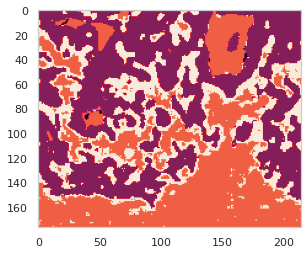

In [10]:
img1 = cell2domain(adata, key='leiden')


In [13]:
resized_pred = cv2.resize(img1, (width_global, height_global), interpolation=cv2.INTER_NEAREST)
cv2.imwrite('cell_segmentation_pred_cluster.jpg', resized_ctmap)

True

True

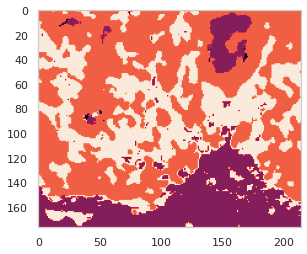

In [11]:
img2 = cell2domain(adata, key='merge_cell_type')

In [14]:
resized_gt = cv2.resize(img2, (width_global, height_global), interpolation=cv2.INTER_NEAREST)
cv2.imwrite('cell_segmentation_gt_cluster.jpg', resized_ctmap)

True

generate ARI

In [17]:
from sklearn.metrics.cluster import adjusted_rand_score

values = []
for cx, cy in zip(adata.obs['cx_g'], adata.obs['cy_g']):
    value = resized_pred[int(cy), int(cx)]
    values.append(value)
adata.obs['ssam_pred'] = values

values = []
for cx, cy in zip(adata.obs['cx_g'], adata.obs['cy_g']):
    value = resized_gt[int(cy), int(cx)]
    values.append(value)
adata.obs['ssam_gt'] = values

ari = adjusted_rand_score(adata.obs['ssam_pred'], adata.obs['ssam_gt'])
print("ari: %.2f"%(ari))

ari: 0.60


Match the cluster

In [21]:
from scipy.optimize import linear_sum_assignment

def _hungarian_match(flat_preds, flat_target, preds_k, target_k):
    num_samples = flat_target.shape[0]
    num_k = preds_k
    num_correct = np.zeros((num_k, num_k))
    for c1 in range(num_k):
        for c2 in range(num_k):
            votes = int(((flat_preds==c1)*(flat_target==c2)).sum())
            num_correct[c1, c2] = votes
    
    match = linear_sum_assignment(num_samples-num_correct)
    match = np.array(list(zip(*match)))
    res = []
    for out_c, gt_c in match:
        res.append((out_c, gt_c))
    return res

In [22]:
preds_k = len(set(adata.obs['ssam_pred']))
target_k = len(set(adata.obs['ssam_gt']))

res = _hungarian_match(adata.obs['ssam_pred'], adata.obs['ssam_gt'], preds_k, target_k)

ssam_pred = adata.obs['ssam_pred']
ssam_gt = adata.obs['ssam_gt']

dicts = {}
for first, sec in res:
    dicts[first] = sec

match_pred = []
for item in ssam_pred:
    match_pred.append(dicts[item])

adata.obs['ssam_match'] = match_pred

draw domain spatial for gt

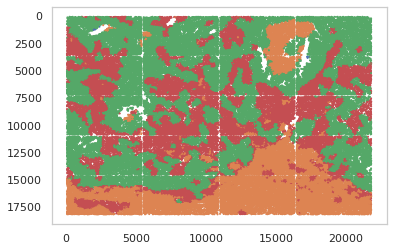

In [23]:
cxg = adata.obs['cx_g']
cyg = adata.obs['cy_g']
colors = [cmap[int(i)] for i in adata.obs['ssam_gt']]
plt.scatter(cxg, cyg, c=colors, s=1)
ax = plt.gca()
ax.invert_yaxis()

draw domain spatial for match

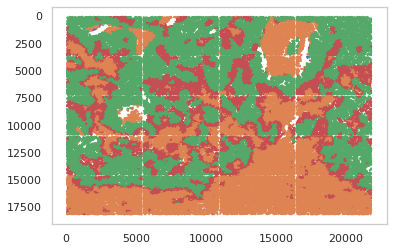

In [24]:
cxg = adata.obs['cx_g']
cyg = adata.obs['cy_g']
colors = [cmap[int(i)] for i in adata.obs['ssam_match']]
plt.scatter(cxg, cyg, c=colors, s=1)
ax = plt.gca()
ax.invert_yaxis()